In [29]:
import pandas as pd
import numpy as np
from pysr import pysr, best
from sklearn import preprocessing

import matplotlib.pylab as plt

import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

import math

In [5]:
data = pd.read_csv("ROP data.csv")

In [6]:
data.head()

,year,name,WOB,ROP data,Db,RPM,UCS,NOC,BR,SR,Dc,NOB
0,2019,SWG,2543.8,6.2,3.75,80,28000,11,25,1,0.51,4
1,2019,SWG,3048.9,11.9,3.75,80,28000,11,25,1,0.51,4
2,2019,SWG,3538.7,19.5,3.75,80,28000,11,25,1,0.51,4
3,2019,SWG,4066.2,28.6,3.75,80,28000,11,25,1,0.51,4
4,2019,SWG,4574.9,36.6,3.75,80,28000,11,25,1,0.51,4


In [7]:
data.columns

Index(['year', 'name ', 'WOB', 'ROP data', 'Db', 'RPM', 'UCS', 'NOC', 'BR',
       'SR', 'Dc', 'NOB'],
      dtype='object')

In [16]:
keep_clmns = ['WOB', 'Db', 'RPM', 'UCS', 'NOC', 'BR', 'SR', 'Dc', 'NOB']
X = data[keep_clmns]

keep_clmns = ['ROP data',]
Y = data[keep_clmns]

In [17]:
X.head()

,WOB,Db,RPM,UCS,NOC,BR,SR,Dc,NOB
0,2543.8,3.75,80,28000,11,25,1,0.51,4
1,3048.9,3.75,80,28000,11,25,1,0.51,4
2,3538.7,3.75,80,28000,11,25,1,0.51,4
3,4066.2,3.75,80,28000,11,25,1,0.51,4
4,4574.9,3.75,80,28000,11,25,1,0.51,4


In [18]:
Y.head()

,ROP data
0,6.2
1,11.9
2,19.5
3,28.6
4,36.6


In [19]:
X.describe().T

,count,mean,std,min,25%,50%,75%,max
WOB,88.0,2967.525501,986.156551,1090.00,2287.50,3033.55165,3692.50,5088.248694
Db,88.0,3.750000,0.000000,3.75,3.75,3.75000,3.75,3.750000
RPM,88.0,123.636364,28.169512,80.00,100.00,120.00000,150.00,160.000000
UCS,88.0,24437.500000,7904.099220,7100.00,28000.00,28000.00000,28000.00,28000.000000
NOC,88.0,12.454545,2.094926,11.00,11.00,11.00000,13.00,16.000000
BR,88.0,19.204545,4.964608,15.00,15.00,15.00000,25.00,25.000000
SR,88.0,1.000000,0.000000,1.00,1.00,1.00000,1.00,1.000000
Dc,88.0,0.463636,0.039717,0.43,0.43,0.43000,0.51,0.510000
NOB,88.0,4.454545,0.500783,4.00,4.00,4.00000,5.00,5.000000


In [20]:
Y.describe().T

,count,mean,std,min,25%,50%,75%,max
ROP data,88.0,33.051984,27.326698,1.646927,12.2,26.125011,44.375,127.7


In [21]:
X_np = np.array(X)
Y_np = np.array(Y)

In [23]:
X_np.shape

(88, 9)

In [24]:

Y_np.shape

(88, 1)

In [25]:
Y_np_flat = Y_np.flatten()

In [27]:
Y_np_flat.shape

(88,)

In [28]:
def greater(x,y):
    if x>y:
        return x
    else:
        return y
    
    
def cube(x):
    return x*x*x



def log1p_abs(x):
    
    return math.log(abs(x) + 1e-8)


def atanh_clip(x):

    return math.log(abs(x) + 1)

def sqrt_abs(x):
    
    return math.sqrt(abs(x))

In [92]:
# learn equation
equation = pysr(X_np,
                Y_np_flat,
                loss="LPDistLoss{3}()",
                niterations=50,
                binary_operators=["plus", "sub", "mult", "pow", "div"],
                verbosity=0)

In [93]:
print(best(equation))

4.05730505196961*x2*Abs(2.323865 - x3/x0)**(-sin(2.5767245*x5))/x8


In [94]:
equation

,Complexity,MSE,score,Equation,sympy_format,lambda_format
0,1,76136.1500,0.000000,x5,x5,<function _lambdifygenerated at 0x000002464406...
1,2,37833.6330,0.699325,exp(x1),exp(x1),<function _lambdifygenerated at 0x000002464406...
2,3,36011.3100,0.049365,(x2 / x1),x2/x1,<function _lambdifygenerated at 0x000002464406...
3,5,32735.6580,0.047684,((x2 / x8) + x8),x2/x8 + x8,<function _lambdifygenerated at 0x000002464406...
4,7,31329.7400,0.021949,((-1.1268727 / x8) * (-1.027131 * x2)),1.1574458832237*x2/x8,<function _lambdifygenerated at 0x000002464405...
5,8,28326.2540,0.100779,"pow((x2 / x8) * -0.73714703, exp(0.1741751))",0.695591781491174*Abs(x2/x8)**1.19026396279456,<function _lambdifygenerated at 0x000002464405...
6,10,24734.9630,0.067786,(((sin(x4) + -0.45304692) / x8) * (-1.746949 -...,(-x2 - 1.746949)*(sin(x4) - 0.45304692)/x8,<function _lambdifygenerated at 0x000002464405...
7,12,24614.8950,0.002433,(((sin(x4) + -0.45304692) / x8) * ((-1.746949 ...,(sin(x4) - 0.45304692)*(-x2 - x8 - 1.746949)/x8,<function _lambdifygenerated at 0x00000246438B...
8,14,22629.1660,0.042056,"pow(((x2 / x8) - pow(x8, cos(x5) + 0.80424494)...",Abs(0.8561559*x2/x8 - 0.8561559*Abs(x8)**(cos(...,<function _lambdifygenerated at 0x000002464405...
9,15,5078.4404,1.494235,"((sin(sin(pow(cos(pow(x3, 1.3436445)), 1.07974...",0.916821296218451*(x2 - cos(x5))*sin(sin(Abs(c...,<function _lambdifygenerated at 0x000002464026...


In [97]:
def best_equation(row):
    x0, x1, x2, x3, x4, x5, x6, x7, x8 = row
    # Y = pow((((pow(x0, 0.58327144) - x5) * 0.92625475) + -29.036554) + ((math.cos(x3) * x1) * (x4 + 4.0001407)), 1.002844)

    # Y = 0.1752066*x2 + 3.2127466*x4*math.cos(x3) + 23.291798 #best equation
    # Y =pow((((pow(x0, 0.58327144) - x5) * 0.92625475) + -29.036554) + ((math.cos(x3) * x1) * (x4 + 4.0001407)), 1.002844)
    Y = 4.05730505196961*x2*abs(2.323865 - x3/x0)**(-1*math.sin(2.5767245*x5))/x8


    return abs(Y)

# row = np.array([2.39e-01, 2.00e-02, 0, 0])
# best_equation(row)
# print(np.apply_along_axis(best_equation, 1, X_nor_np))
estimated = np.apply_along_axis(best_equation, 1, X_np)

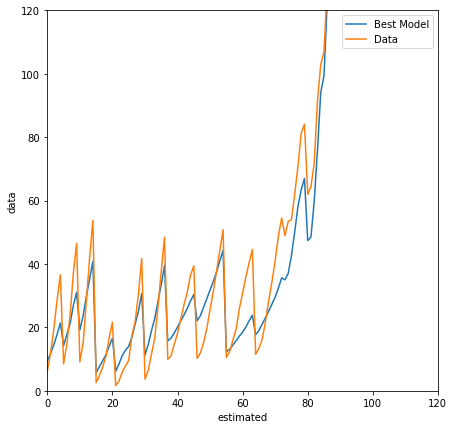

In [98]:
plt.figure(figsize=(7,7))
plt.plot(estimated, label="Best Model")
plt.plot(Y_np, label="Data")
plt.xlim(0,120),plt.xlabel("estimated")
plt.ylim(0,120),plt.ylabel("data")
plt.legend()

((0, 120), Text(0, 0.5, 'data'))

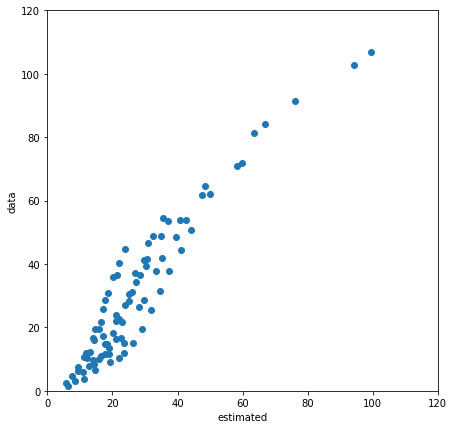

In [99]:
plt.figure(figsize=(7,7))
plt.scatter(estimated, Y_np)
plt.xlim(0,120),plt.xlabel("estimated")
plt.ylim(0,120),plt.ylabel("data")